# Power Law Distributions

$$ p(x) = cx^{-\alpha} $$
$$ \text{a.k.a: } \log(p(x)) = -\alpha\log(x) + c $$

## Previously on this program: 
Last time (see 'long-tail-distributions-001') I talked about power law distributions, I talked about them in the context of long tail distributions as a whole. Before launching into a discussion of the power law distributions, I want to reiterate that *power laws are just **one** type of long tail distribution*. 
- A long tail distribution is *any* distribution with more weight in the tail than the exponential distribution
- One other example of a commonly occurring long tail distribution is the log-normal distribution
- Many empirical distributions are long tail for only some parts of the domain

## Today:
- Define a power law distribution
- Show some effective ways of examining a power law distribution
- Demonstrate a commonly proposed generative process for power laws found in the world

## Goals:
Long tail distributions, and even power law distributions, show up with some regularity in empirical Twitter data. Distributions such as "the number of likes a Tweet recieves" seem to follow a long tail distribution (possibly even explicitly a power law distribution).

Understanding how to recognize long tail distributions, how to represent them, how to test for them, and where they might be coming from could help us indentify underlying processes for the emergence fo certain patterns in Twitter data.

## Credit where credit is due:
Today's RST is brought to you by the in part by the lovely Dr MEJ Newman, and his 2006 paper: *Power laws, Pareto distributions and Zipf's law*. This notebook is by me, Fiona Pigott.

In [224]:
# Plotting library
import matplotlib.pyplot as plt
%matplotlib inline

# mathematics
from math import exp, pi, sqrt, log
from numpy import linspace, hstack, round, random, arange, mean, logspace, argmax, array
from collections import Counter
from random import sample, choice
from random import uniform
#from functools import reduce

## Power law: "*y* varies as a function of some power ($\alpha$) of *x*"

$$ p(x) = cx^{-\alpha} $$
$$ \text{a.k.a: } \log(p(x)) = -\alpha\log(x) + c $$

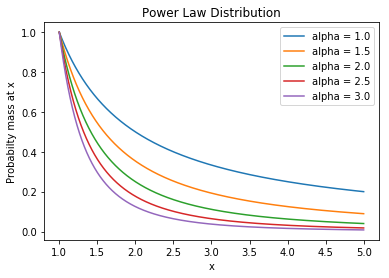

In [32]:
def power_law(x, alpha):
    '''
    x: iterable of x values
    alpha: parameter alpha
    '''
    return [point**(-alpha) for point in x]

# x values
x = linspace(1,5,10000)
alphas = linspace(1,3,5)
for alpha in alphas:
    _ = plt.plot(x, power_law(x, alpha), '-', markersize = 1)
    _ = plt.ylabel("Probabilty mass at x")
    _ = plt.xlabel("x")
    _ = plt.title("Power Law Distribution")
_ = plt.legend(["alpha = {}".format(round(a,2)) for a in alphas], loc = 1)

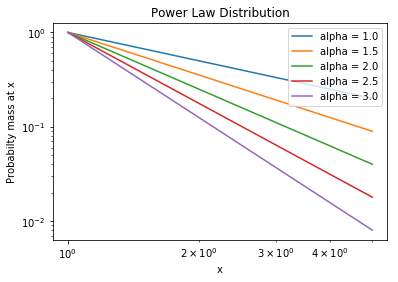

In [33]:
for alpha in alphas:
    _ = plt.loglog(x, power_law(x, alpha), '-', markersize = 1)
    _ = plt.ylabel("Probabilty mass at x")
    _ = plt.xlabel("x")
    _ = plt.title("Power Law Distribution")
_ = plt.legend(["alpha = {}".format(round(a,2)) for a in alphas], loc = 1)

## Sampling a power law distribution

I'm going to generate a sample of power-law distributed data using a transformation method--by using a fuctional transformation on uniformly distributed random data to get power law distributed random data.

- generate a random real number r uniformly distributed in the range $0 \leq r < 1$
- compute $x = x_{min}(1 -r)^{-1/(\alpha -1)}$
- $x$ is a power law distributed number in the rangoe $x_{min} \leq x < \infty$ with an exponent $\alpha$

I want to show how sampling a power law is subject to lots of noise--especially in the tail--and how to see that in your representations of data.

In [198]:
# generate 100000 samples of a uniform distribution on 0,1
xmin = 1
r = random.uniform(0,1,10**6)
# generate the power law distributed samples
# set alpha
alpha = 2.5
power_law_samples = [xmin*(1-sample)**(-1/(alpha-1)) for sample in r]

## Looking at a power law distribution

From Newman: 
>A histogram of a quantity with a power-law distribution appears as a straight line when plotted on logarithmic scales. Just making a simple histogram, however, and plotting it on log scales to see if it looks straight is, in most cases, a poor way proceed.

Simply plotting a histogram of an empirical distribution to determine whether or not it is power law distributed is "a poor way to proceed" because of the very noisy data in the low-frequency very large values in the tail of the distribution. Newman suggests a few different ways of looking at power law distribtuions:

1. Simple histogram
2. Histogram on logarithmic scales
3. Histogram with logarithmic bin sizes
4. A cumulative distribution, or rank-frequncy plot (we looked at these in log-tail-distributions-001)

### A Simple histogram

In [266]:
def simple_histogram(samples, bin_sizes = None, num_bins = None):
    # sort the samples
    sorted_samples = sorted(samples)
    # grab the max for the bins
    max_val = max(samples)
    # min is 0, but not inclusive
    min_val = 0
    # either create bins by interval or by size
    if bin_sizes is not None:
        intervals = arange(min_val,max_val+bin_sizes,bin_sizes)
    if num_bins is not None:
        intervals = linspace(min_val,max_val,num_bins)
    # list of tuples defining the bins
    list_bins = list(zip(intervals,intervals[1:]))
    dict_bins = {x: 0 for x in list_bins}
    # put each sample into a bin
    i = 0
    for s in sorted_samples:
        if (s > list_bins[i][0]) and (s <= list_bins[i][1]):
            dict_bins[list_bins[i]] += 1
        else:
            while not ((s > list_bins[i][0]) and (s <= list_bins[i][1])):
                i += 1
            dict_bins[list_bins[i]] += 1
    return dict_bins

def plot_histogram(histogram):
    histogram_items = sorted(list(histogram.items()),key = lambda x:x[0])
    x_vals = [mean([x[0][0],x[0][1]]) for x in histogram_items]
    y_vals = [x[1] for x in histogram_items]
    return x_vals, y_vals

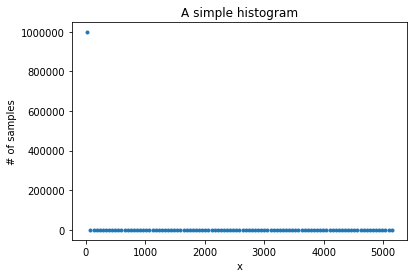

In [200]:
x,y = plot_histogram(simple_histogram(power_law_samples,num_bins = 100))
_ = plt.plot(x,y,'.')
_ = plt.title("A simple histogram")
_ = plt.ylabel("# of samples")
_ = plt.xlabel("x")

# A histogram on a log-log scale

From Newman:
>  Notice how noisy the results get in the tail towards the
right-hand side of the panel. This happens because the number of samples in the bins becomes small and statistical fluctuations are therefore large as a fraction of sample number. The power-law distribution dwindles in this region, meaning that each bin only has a few samples in it, if any.

Noise in the tail is one of the reasons that a log-log histogram isn't always the clearest way to plot a power law distribution. 

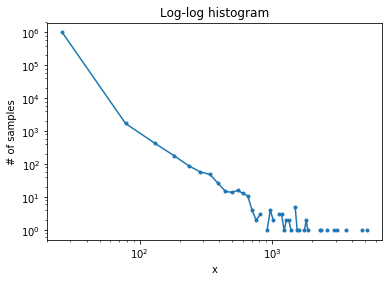

In [201]:
x,y = plot_histogram(simple_histogram(power_law_samples,num_bins = 100))
_ = plt.loglog(x,y,'.-')
_ = plt.title("Log-log histogram")
_ = plt.ylabel("# of samples")
_ = plt.xlabel("x")

# A log-log histogram with logarithmic binning

From Newman:
> An alternative solution is to vary the width of the bins in the histogram [each bin is a fixed multiple wider than the one before it]. If we are going to do this, we must also normalize the sample counts by the width of the bins they fall in.

In [272]:
def log_histogram(samples, num_bins = None):
    # sort the samples
    sorted_samples = sorted(samples)
    # grab the max for the bins
    max_val = max(samples)
    # min is 0, but not inclusive
    min_val = 0
    # create logarithmically spaced bins
    intervals = logspace(min_val,log(max_val+10,10),num_bins,base = 10)
    #return intervals
    # list of tuples defining the bins
    list_bins = list(zip(intervals,intervals[1:]))
    dict_bins = {x: 0 for x in list_bins}
    # put each sample into a bin
    i = 0
    for s in sorted_samples:
        if (s > list_bins[i][0]) and (s <= list_bins[i][1]):
            dict_bins[list_bins[i]] += 1
        else:
            while not ((s > list_bins[i][0]) and (s <= list_bins[i][1])):
                i += 1
            dict_bins[list_bins[i]] += 1
    return dict_bins

def plot_log_histogram(histogram):
    histogram_items = sorted(list(histogram.items()),key = lambda x:x[0][0])
    x_vals = [10**mean([log(x[0][0],10),log(x[0][1],10)]) for x in histogram_items]
    y_vals = [x[1]/(x[0][1] - x[0][0]) for x in histogram_items]
    return x_vals, y_vals

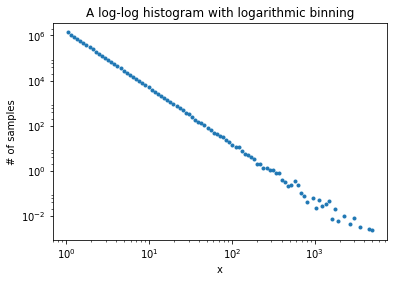

In [273]:
x,y = plot_log_histogram(log_histogram(power_law_samples,num_bins = 100))
_ = plt.loglog(x,y,'.')
_ = plt.title("A log-log histogram with logarithmic binning")
_ = plt.ylabel("# of samples")
_ = plt.xlabel("x")

## Plotting the cumulative distribution

In [259]:
def cumulative_dist(samples,bin_sizes = None, num_bins = None):
    # count the number of samples with a value greater than X
    # sort the samples
    sorted_samples = array(sorted(samples))
    # grab the max for the bins
    max_val = max(samples)
    # min is 0, but not inclusive
    min_val = 0
    # either create bins by interval or by size
    if bin_sizes is not None:
        intervals = arange(min_val,max_val+bin_sizes,bin_sizes)
    if num_bins is not None:
        intervals = linspace(min_val,max_val,num_bins)
    # put each sample into a bin
    cum_dist = []
    for i in intervals:
        cum_dist.append(len(sorted_samples) - argmax(sorted_samples > i))
    return intervals, cum_dist

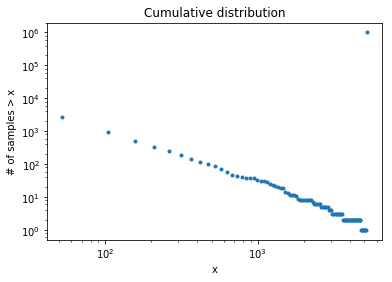

In [270]:
x,y = cumulative_dist(power_law_samples,num_bins = 100)
_ = plt.loglog(x,y,'.')
_ = plt.title("Cumulative distribution")
_ = plt.ylabel("# of samples > x")
_ = plt.xlabel("x")

## Estimating $\alpha$ from the sampled data

A simple method of estimating $\alpha$ is the following:
$$ \alpha =  1 + \sum_{i = 1}^n \ln(\frac{x_i}{x_{min}})^{-1} $$

In [279]:
xmin = min(power_law_samples)
est_alpha = 1 + (len(power_law_samples) * sum([log(x/xmin) for x in power_law_samples])**(-1))
print("The estimated alpha is: {}".format(est_alpha))
print("The actual alpha is: {}".format(alpha))

The estimated alpha is: 2.500435049650944
The actual alpha is: 2.5


## The Yule process (a.k.a: "preferential attachment")

From Newman: 
> A rich-get-richer mechanism in which the most populous cities or best-selling books get more inhabitants or sales in proportion to the number that they already have.

I'm particularly interested in this generative process because it seems like it could be a good hypothesis for explaining Twitter platform distributions like "the number of Likes/RTs per Tweet."

In networks, this process is commonly labeled as "preferential attachment."

There is a functional form for the distribution resulting from the Yule process, but I don't think that's as informative as seeing the process in action. Let's simulate a simple rich-get-richer process.

In [283]:
# simulate the yule process
# start with, say, a set of 100000 nodes, with a single link
# I'm only interested in counting degree distributions, so I will simply record the links by 
# augmenting the degree count of 2 nodes by 1
N = {x:0 for x in range(0,10**6)}
# we'll do this 100,000 - 1 times:
#    in order, each node gets a single link
#    the probability that any link connects to an existing node is proportional to that node's degree
#    note: the probability of a node with no links getting a new link is 0
in_network_nodes = [0]
nodes_by_degree = [0]
for x in range(1,10**6):
    in_network_nodes.append(x)
    N[x] += 1
    gets_a_link = choice(nodes_by_degree)
    N[gets_a_link] += 1
    nodes_by_degree.extend([x,gets_a_link])
# the probability that the new link connects to an existing node is proportional to that node's degree

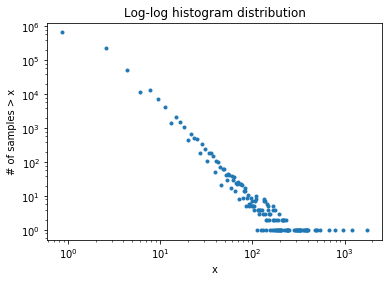

In [284]:
x,y = plot_histogram(simple_histogram(list(N.values()),num_bins = 1000))
_ = plt.loglog(x,y,'.')
_ = plt.title("Log-log histogram distribution")
_ = plt.ylabel("# of samples > x")
_ = plt.xlabel("x")

In [285]:
xmin = min(list(N.values()))
est_alpha = 1 + (len(list(N.values())) * sum([log(x/xmin) for x in list(N.values())])**(-1))
print("The estimated alpha is: {}".format(est_alpha))

The estimated alpha is: 3.6776351905196907
